### Import libraries and define subject path

In [5]:
# This is our preprocessing script.
# We select one recording, clean stuff and then perform the ICA
# During this process, we save all bad components segments and channels

import sys
import os.path as op
module_path = op.abspath(op.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import mne

from data_analysis.functions_preprocessing import \
    (split_raws, mark_bads, save_bads, run_ica, save_ica)

subject_dir = '/net/store/nbp/projects/hyperscanning/hyperscanning-2.0/mne_data/sourcedata/'

#%matplotlib notebook
#%matplotlib tk
#%matplotlib qt
#%matplotlib ipympl
%matplotlib widget

import matplotlib
#matplotlib.use('Qt5Agg')
matplotlib.get_backend()

'module://ipympl.backend_nbagg'

## Define the subject you want to clean

In [2]:
subj_pair = input("Please Type in, which subject pair you want to clean.\n"
                  "For the pilot study, possible choices are:\n"
                  "[202, 203, 204, 205, 206, 207, 208, 209, 211, 212]\n")

participant = input("\nPlease Type in, which subject pair you want to clean.\n"
                    "Type: 0 for the first participant and: 1 for the second.\n")

Please Type in, which subject pair you want to clean.
For the pilot study, possible choices are:
[202, 203, 204, 205, 206, 207, 208, 209, 211, 212]
204

Please Type in, which subject pair you want to clean.
Type: 0 for the first participant and: 1 for the second.
0


## Load and prepare the EEG recording

In [3]:
# define the subjects id and its path
subj_id = "sub-{0}_p-{1}".format(subj_pair, participant)
subs_path = subject_dir + "sub-{0}/eeg/sub-{0}_task-hyper_eeg.fif".format(subj_pair)

## overwrite it for the test
# TODO: This line should be removed for the actual cleaning
subj_id = "test_2"

# load the data
combined_raw = mne.io.read_raw_fif(subs_path, preload=True)

# split the subjects and delete the raw file
raw = split_raws(combined_raw)[int(participant)]
del combined_raw

# set reference
raw.set_eeg_reference(["Cz"])

# filter ?
raw.filter(l_freq=0.1, h_freq=120)
raw.notch_filter(freqs=[16.666666667, 50]) # bandstop the train and power grid

Opening raw data file /net/store/nbp/projects/hyperscanning/hyperscanning-2.0/mne_data/sourcedata/sub-204/eeg/sub-204_task-hyper_eeg.fif...


<ipython-input-3-4a3129ac1b06>:10: RuntimeWarning: This filename (/net/store/nbp/projects/hyperscanning/hyperscanning-2.0/mne_data/sourcedata/sub-204/eeg/sub-204_task-hyper_eeg.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  combined_raw = mne.io.read_raw_fif(subs_path, preload=True)


Isotrak not found
    Range : 0 ... 3537048 =      0.000 ...  3454.148 secs
Ready.
Reading 0 ... 3537048  =      0.000 ...  3454.148 secs...
EEG channel type selected for re-referencing
Applying a custom EEG reference.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 1.2e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 120.00 Hz
- Upper transition bandwidth: 30.00 Hz (-6 dB cutoff frequency: 135.00 Hz)
- Filter length: 33793 samples (33.001 sec)

Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0

<Raw | sub-204_task-hyper_eeg.fif, 80 x 3537049 (3454.1 s), ~2.11 GB, data loaded>

## Plot the data and clean it

In [4]:
# mark the channels and save them
fig = mark_bads(raw, subj_id, sensor_map=True)
fig.canvas.key_press_event('a')

Loading preexisting marked channels
Additionally marked channels will be added to file.
Loading preexisting marked segments
Additionally marked segments will be added to file.
Plotting data. Click on channels to mark them as bad. Type 'a' to enter Annotations mode and mark bad segments.
Close the plot to carry on with preprocessing.


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

## Save the marked channels and segments

In [5]:
save_bads(raw, subj_id)

Do you really want to save the data? Falsely marked data might be hard to remove.
Enter 'save' or 's' to save the data. Else, changes will be discarded.
s


## Run (or load) the ICA and plot all components

Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 2 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 2.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 1.00 Hz)
- Filter length: 1691 samples (1.651 sec)

Fitting ICA to data using 57 channels (please be patient, this may take a while)
Inferring max_pca_components from picks
Omitting 14179 of 5675446 (0.25%) samples, retaining 5661267 (99.75%) samples.
Selecting by number: 25 components
Fitting ICA took 340.4s.


<IPython.core.display.Javascript object>


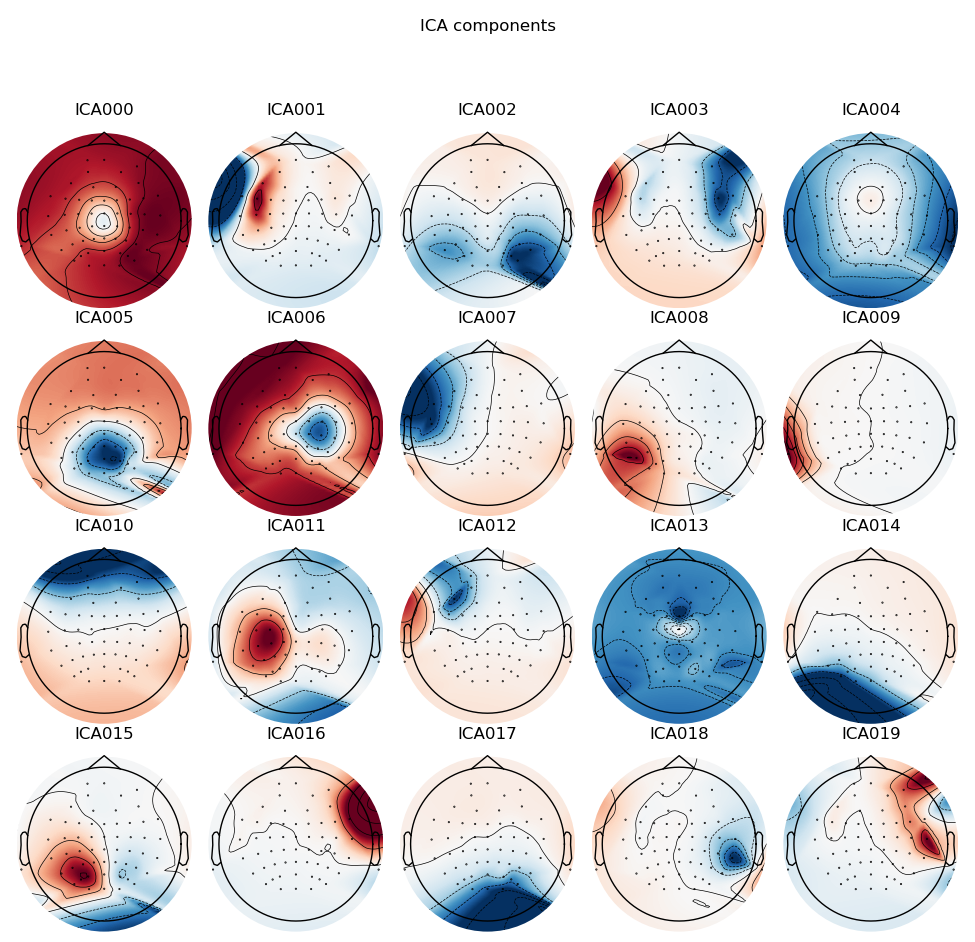

<IPython.core.display.Javascript object>


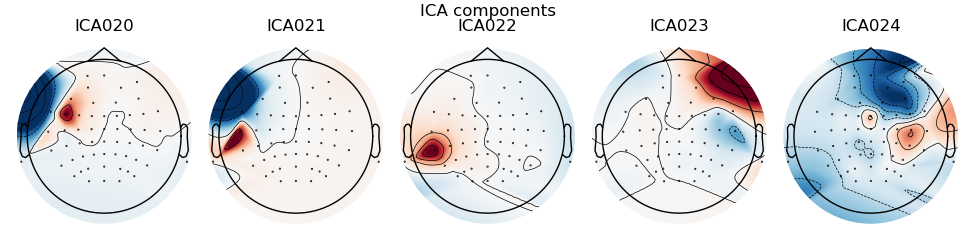

In [6]:
# filter again for ICA
raw.filter(l_freq=2, h_freq=None)

# run the ICA and save the marked components
ica = run_ica(raw, subj_id, n_components=25, method="fastica")

## Choose specific component properties to inspect

Please type in which components you want to further inspect.
E.G. 3, 4,15 for components 3, 4, and 15.
7,6


<IPython.core.display.Javascript object>


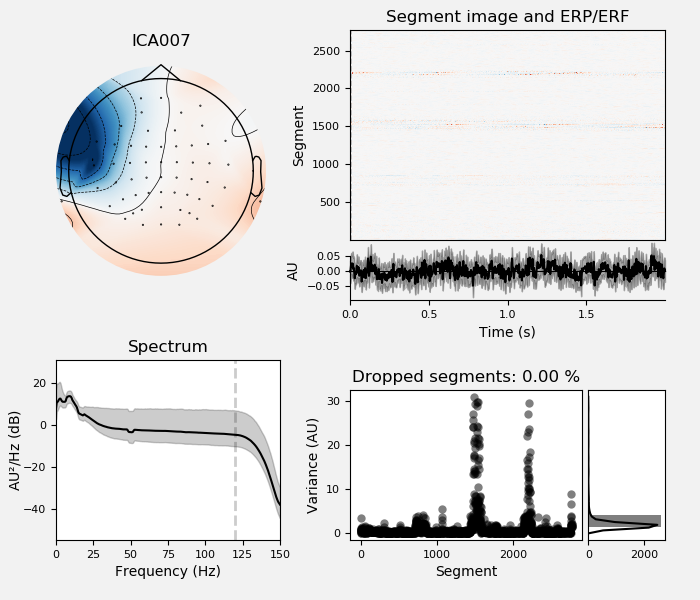

    Using multitaper spectrum estimation with 7 DPSS windows
2771 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped


<IPython.core.display.Javascript object>


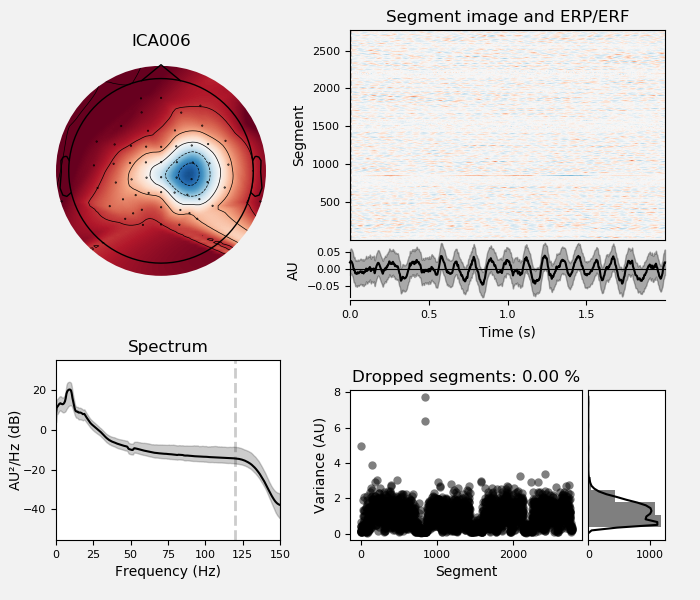

2771 matching events found
No baseline correction applied
Not setting metadata
0 projection items activated
0 bad epochs dropped


In [8]:
if len(ica.ch_names) > 64 - len(raw.info["bads"]):
    raise ValueError("\nYou excluded additional channels from the raw "
                     "file since the initial fit of the ICA.\n"
                     "Because of this, the property plots won't work.\n"
                     "You might consider deleting the current ICA file "
                     "and running a new ICA on the remaining channels.\n")

# FIXME: We (temporarily) ignore bad segments in order to
#  inspect elements in the ICA, which cannot be done ATM
#  probably due to a bug in MNE. However it would be better to
#  remove the bad segments instead.
raw_tmp = raw.copy().set_annotations(None)


inp = input("Please type in which components you want to further "
            "inspect.\nE.G. 3, 4,15 for components 3, 4, and 15.\n")

inp = [int(n) for n in inp.split(",") if n != ""]

if len(inp) > 0:
    ica.plot_properties(raw_tmp, picks=inp, reject=None)
    
del raw_tmp

## Exclude specific ICA components

In [10]:
print("Excluded ICA components: ", ica.exclude)

inp = input("\nPlease type in which components you want to exclude.\n"
            "E.G. 2, 3,14 for components 2, 3, and 14.\n")

bad_comps = [int(comp) for comp in inp.split(",") if comp != ""]
bad_comps = [comp for comp in set(bad_comps) if comp not in ica.exclude]

ica.exclude.extend(bad_comps)
print("\nExcluded ICA components: ", ica.exclude)

Excluded ICA components:  [1, 2, 3, 4]

Please type in which components you want to exclude.
E.G. 2, 3,14 for components 2, 3, and 14.
2,2,2,3,1

Excluded ICA components:  [1, 2, 3, 4]


## Save the ICA and its excluded components

In [11]:
inp = input("Do you really want to save the components?\n"
            "Enter 'save' or 's' to save the data. Else, "
            "changes will be discarded.\n")

if inp[0] == "s":
    save_ica(ica, subj_id)

Do you really want to save the components?
Enter 'save' or 's' to save the data. Else, changes will be discarded.
s
Writing ICA solution to /net/store/nbp/projects/hyperscanning/study_project/dirk/NBP_Hyperscanning/data_analysis/bads/bad_components/test_2-ica.fif...


### give everyone access to the new marked files you've created

In [8]:
!cd /net/store/nbp/projects/hyperscanning/study_project
!chown -hR $USER:nbp *; chmod -R 770 *



### Everything done. Thanks for cleaning :)